In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import pickle

## Loading data

#### Lennard-Jones fluid

In [10]:
barostrides=np.array((1,2,5,10,20,50,100),dtype=int) # explored Np values
taups=np.array((0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0,20.0,50.0,100.0)) # explored tau_p values
barotypes=("E","R","T") # Euler, Reversible Euler, Trotter-based
baroscalevs=("T","F") # True/False

In [4]:
usePickle=True
# If set to True, in the following cell load from previously saved data in the pickle format

In [5]:
path='/scratch/bussi/simplemd-barostat/xyz/'
if usePickle:
    traj=pickle.load(open("traj_all.p","rb"))
else:
    traj={}
    for taup in taups:
        for barostride in barostrides:
            for barotype in barotypes:
                for baroscalev in baroscalevs:
                    try:
                        traj[taup,barotype,baroscalev,barostride]=np.array(
                            pd.read_csv(path + 
                        "new_energies_"+str(taup)+"_"+barotype+"_"+baroscalev+"_"+str(barostride)+".dat",
                            header=None,sep=" ",usecols=[4,5]),dtype=float
                        )
                    except FileNotFoundError:
                        pass
    # discard first quarter
    for k in traj.keys():
        traj[k]=traj[k][int(len(traj[k])/4):,:]
    pickle.dump(traj,open("traj_all.p","wb")) #

print("Number of frames per simulation")
for k in traj.keys():
    print(k,len(traj[k]))

Number of frames per simulation
(0.01, 'E', 'T', 1) 750000
(0.01, 'E', 'F', 1) 750000
(0.01, 'R', 'T', 1) 750000
(0.01, 'R', 'F', 1) 750000
(0.01, 'T', 'T', 1) 750000
(0.01, 'T', 'F', 1) 750000
(0.02, 'E', 'T', 1) 750000
(0.02, 'E', 'F', 1) 750000
(0.02, 'R', 'T', 1) 750000
(0.02, 'R', 'F', 1) 750000
(0.02, 'T', 'T', 1) 750000
(0.02, 'T', 'F', 1) 750000
(0.05, 'E', 'T', 1) 750000
(0.05, 'E', 'F', 1) 750000
(0.05, 'R', 'T', 1) 750000
(0.05, 'R', 'F', 1) 750000
(0.05, 'T', 'T', 1) 750000
(0.05, 'T', 'F', 1) 750000
(0.1, 'E', 'T', 1) 750000
(0.1, 'E', 'F', 1) 750000
(0.1, 'R', 'T', 1) 750000
(0.1, 'R', 'F', 1) 750000
(0.1, 'T', 'T', 1) 750000
(0.1, 'T', 'F', 1) 750000
(0.2, 'E', 'T', 1) 750000
(0.2, 'E', 'F', 1) 750000
(0.2, 'R', 'T', 1) 750000
(0.2, 'R', 'F', 1) 750000
(0.2, 'T', 'T', 1) 750000
(0.2, 'T', 'F', 1) 750000
(0.5, 'E', 'T', 1) 750000
(0.5, 'E', 'F', 1) 750000
(0.5, 'R', 'T', 1) 750000
(0.5, 'R', 'F', 1) 750000
(0.5, 'T', 'T', 1) 750000
(0.5, 'T', 'F', 1) 750000
(1.0, 'E', 'T'

#### Liquid water:

In [3]:
# pcoupl = C-rescale (stochastic cell rescaling)
cr_tp01=np.loadtxt('./SI_data/cr_tp01.xvg',comments=['#', '@'])[5000:]
cr_tp05=np.loadtxt('./SI_data/cr_tp05.xvg', comments=['#', '@'])[5000:]
cr_tp1=np.loadtxt('./SI_data/cr_tp1.xvg', comments=['#', '@'])[5000:]
cr_tp2=np.loadtxt('./SI_data/cr_tp2.xvg', comments=['#', '@'])[5000:]

#### Membrane simulation:

In [5]:
pr_memb=np.loadtxt("./SI_data/memb_pr.xvg",comments=["#","@"]) # pcoupl = Parrinello-Rahman
cr_memb=np.loadtxt("./SI_data/memb_cr.xvg",comments=["#","@"]) # pcoupl = C-rescale (stochastic cell rescaling)
bere_memb=np.loadtxt("./SI_data/memb_bere.xvg",comments=["#","@"]) # pcoupl = Berendsen

#### Table with performances:

In [4]:
pr_perfs=np.loadtxt("./SI_data/perform_pr.dat")[:,1:] # pcoupl = Parrinello-Rahman
cr_perfs=np.loadtxt("./SI_data/perform_cr.dat")[:,1:] # pcoupl = C-rescale (stochastic cell rescaling)
nvt_perfs=np.loadtxt("./SI_data/perform_nvt.dat") # pcoupl = no (NVT simulation)

## 1. Distribution of the volume: checking with NVT calculations

We run NVT calculations of the Lennard-Jones fluid. Since the average volume from the NPT simulations is ~ 445 and stddev ~ 15, we generate a set of volumes in the range 445 +- 4* stddev. We use a broad range to make sure we compute the correct variance.

In [7]:
nvt_vol=np.int_(np.linspace(445-60,445+60,41))

In [8]:
# print list of Volume values to be pasted in run_nvt
for i in nvt_vol:
    print(str(i)+" ",end='')

385 388 391 394 397 400 403 406 409 412 415 418 421 424 427 430 433 436 439 442 445 448 451 454 457 460 463 466 469 472 475 478 481 484 487 490 493 496 499 502 505 

Notice that the original simplemd.x has been modified to write the virial in an extra column.

In [9]:
usePickle_nvt=True
# If set to True, in the following cell load from previously saved data in the pickle format

In [11]:
if usePickle_nvt:
    traj_nvt=pickle.load(open("traj_nvt.p","rb"))
else:
    traj_nvt={}
    for i in nvt_vol:
        traj_nvt[i]=np.array(
                        pd.read_csv(
                    "nvt_energies_"+str(i)+".dat",
                        header=None,sep=" ",usecols=[5,6,4]),dtype=float
                    )[:,(1,2,0)] # weird way to keep the order (5,6,4)
    # discard first quarter
    for k in traj_nvt.keys():
        traj_nvt[k]=traj_nvt[k][int(len(traj_nvt[k])/4):,:]
    
    pickle.dump(traj_nvt,open("traj_nvt.p","wb"))

print("Number of frames per simulation")
for k in traj_nvt.keys():
    print(k,len(traj_nvt[k]))

Number of frames per simulation
385 750000
388 750000
391 750000
394 750000
397 750000
400 750000
403 750000
406 750000
409 750000
412 750000
415 750000
418 750000
421 750000
424 750000
427 750000
430 750000
433 750000
436 750000
439 750000
442 750000
445 750000
448 750000
451 750000
454 750000
457 750000
460 750000
463 750000
466 750000
469 750000
472 750000
475 750000
478 750000
481 750000
484 750000
487 750000
490 750000
493 750000
496 750000
499 750000
502 750000
505 750000


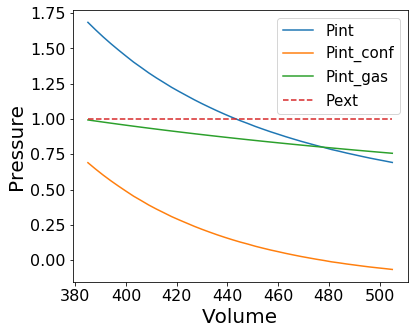

In [12]:
plt.figure(figsize=(6,5))

vol=[]
pint=[]
pint_conf=[]
pint_gas=[]
for V in traj_nvt.keys():
    vol.append(V)
    pint_conf.append(np.average(traj_nvt[V][:,1]/(3*traj_nvt[V][:,0])))
    pint_gas.append(np.average((256*3-3)/3*1.5/traj_nvt[V][:,0]))
    pint.append(np.average(traj_nvt[V][:,1]/(3*traj_nvt[V][:,0])+(256*3-3)/3*1.5/traj_nvt[V][:,0]))
vol=np.array(vol)
pint=np.array(pint)
pint_conf=np.array(pint_conf)
pint_gas=np.array(pint_gas)
plt.plot(vol,pint,label="Pint")
plt.plot(vol,pint_conf,label="Pint_conf")
plt.plot(vol,pint_gas,label="Pint_gas")
plt.plot(vol,[1]*len(vol),"--",label="Pext")
plt.ylabel('Pressure',fontname='Sans',fontsize=20) 
plt.xlabel('Volume',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.legend(fontsize=15)

plt.show()
#plt.savefig('fig_SI_1a.png',dpi=300,bbox_inches='tight')

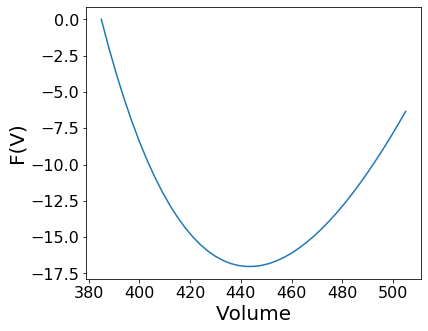

In [13]:
plt.figure(figsize=(6,5))

F=[]
F.append(0.0)
for i in range(len(pint)-1):
    F.append(F[-1]-(0.5*(pint[i+1]+pint[i])-1.0)*(vol[i+1]-vol[i]))
F=np.array(F)
P=np.exp(-F/1.5)
plt.plot(vol,F)
plt.ylabel('F(V)',fontname='Sans',fontsize=20) 
plt.xlabel('Volume',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)

plt.show()
#plt.savefig('fig_SI_1b.png',dpi=300,bbox_inches='tight')

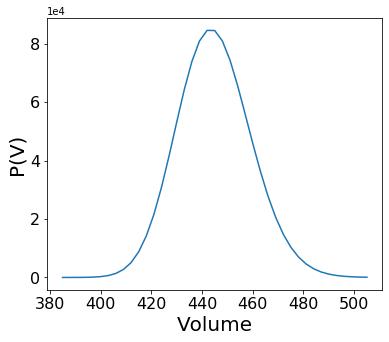

In [14]:
plt.figure(figsize=(6,5))

plt.plot(vol,P)
plt.ylabel('P(V)',fontname='Sans',fontsize=20) 
plt.xlabel('Volume',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.show()
#plt.savefig('fig_SI_1c.png',dpi=300,bbox_inches='tight')

In [16]:
print("average  Volume",np.average(vol,weights=P))
print("variance of the Volume",np.average(vol**2,weights=P)-np.average(vol,weights=P)**2)

average  Volume 444.91383426025806
variance of the Volume 208.2900606287585


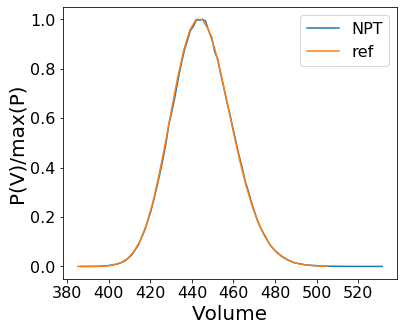

In [17]:
# Herein, we just compare with one of the simulations above with reasonable settings:
# Euler integrator
# taup=1.0
# nstbaro=1
plt.figure(figsize=(6,5))
h=np.histogram(traj[(1.0,'E','T', 1)][:,1],bins=100)
plt.plot((h[1][:-1]+h[1][1:])/2,h[0]/np.max(h[0]),label="NPT")
plt.plot(vol,P/np.max(P),label="ref")
plt.legend(fontsize=16)
plt.ylabel('P(V)/max(P)',fontname='Sans',fontsize=20) 
plt.xlabel('Volume',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)

plt.show()
#plt.savefig('fig_SI_1d.png',dpi=300,bbox_inches='tight')

## 2. Lennard-Jones fluid: autocorrelation function (ACF)

In [18]:
def autocorr2(x):
    r2=np.fft.ifft(np.abs(np.fft.fft(x))**2).real
    c=(r2/x.shape-np.mean(x)**2)/np.std(x)**2
    return c[:len(x)//2]

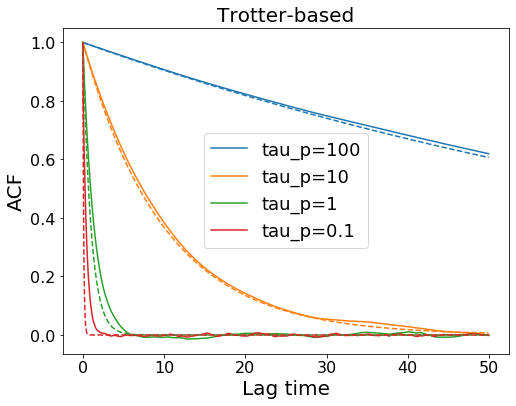

In [20]:
plt.figure(figsize=(8,6))

xmax=1000

plt.plot(np.arange(xmax)*0.05,autocorr2(traj[(100.0,'T','T',1)][:,1])[:xmax],label="tau_p=100")
plt.plot(np.arange(xmax)*0.05,autocorr2(traj[(10.0,'T','T',1)][:,1])[:xmax],label="tau_p=10")
plt.plot(np.arange(xmax)*0.05,autocorr2(traj[(1.0,'T','T',1)][:,1])[:xmax],label="tau_p=1")
plt.plot(np.arange(xmax)*0.05,autocorr2(traj[(0.1,'T','T',1)][:,1])[:xmax],label="tau_p=0.1")

plt.plot(np.arange(xmax)*0.05,np.exp(-np.arange(xmax)*0.05/100.0),"--",color='C0')
plt.plot(np.arange(xmax)*0.05,np.exp(-np.arange(xmax)*0.05/10.0),"--",color='C1')
plt.plot(np.arange(xmax)*0.05,np.exp(-np.arange(xmax)*0.05/1.0),"--",color='C2')
plt.plot(np.arange(xmax)*0.05,np.exp(-np.arange(xmax)*0.05/0.1),"--",color='C3')

plt.ylabel('ACF',fontname='Sans',fontsize=20) 
plt.xlabel('Lag time',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.title("Trotter-based",fontsize=20)
plt.legend(fontsize=18)

plt.show()
#plt.savefig('fig_SI_2.png',dpi=300,bbox_inches='tight')

## 3. Lennard-Jones fluid: dependence on tau_p and nstpc, non-scaling implementation

In [21]:
def block_error(series):
    blocksize=int(len(series)/30)
    err_ave=[]
    err_var=[]
    ave_all=np.average(series)
    var_all=np.std(series)**2
    var2_all=np.average(((series-ave_all)**2-var_all)**2)
    while 3*blocksize<len(series):
        nblocks=int(len(series)/blocksize)
        ave=[]
        var=[]
        for i in range(nblocks):
            ave.append(np.average(series[i*blocksize:(i+1)*blocksize]))
            var.append(np.average((series[i*blocksize:(i+1)*blocksize]-ave_all)**2))
        err_ave.append(np.std(ave)/np.sqrt(nblocks-1))
        err_var.append(np.std(var)/np.sqrt(nblocks-1))
        blocksize=int(blocksize*1.5)+1
    return (ave_all,var_all,
            np.max(err_ave),np.max(err_var),
            0.5*np.max(err_ave)**2/var_all*len(series),
            0.5*np.max(err_var)**2/var2_all*len(series)
           )

In [22]:
vol={}
sigma2={}
err_vol={}
err_sigma2={}
tau_vol={}
tau_sigma2={}
drift={}
for k in traj.keys():
    (vol[k],sigma2[k],
     err_vol[k],err_sigma2[k],
     tau_vol[k],tau_sigma2[k]
    )=block_error(traj[k][:,1])
    drift[k]=np.polyfit(
        range(len(traj[k][::100,0])),
        traj[k][::100,0],1)[0]/1000.0 # drift PER STEP

In [23]:
barotypes_l={
    'E':'Euler','R':'Reversible Euler','T':'Trotter-based',
    'Es':'Euler','Rs':'Reversible Euler','Ts':'Trotter-based'}
colors_l={
    'E':'black','R':'C6','T':'C9',
    'Es':'black','Rs':'C6','Ts':'C9'}

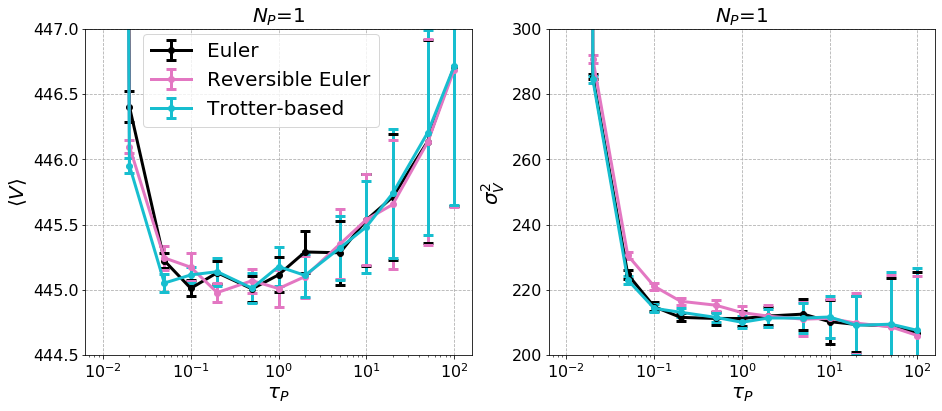

In [24]:
baroscalevs=("F") 
baroscalev=("F")

plt.figure(figsize=(8,6))

plt.subplot(121)
for barotype in barotypes:
    for baroscalev in baroscalevs:
        y=[]
        e=[]
        for taup in taups:    
            y.append(vol[taup,barotype,baroscalev,1])
            e.append(err_vol[taup,barotype,baroscalev,1])
        label=barotype
        if baroscalev=="T":
            label+="s"
        plt.errorbar(taups,y,e,label=barotypes_l[label],
                    linewidth=3,capsize=5,capthick=3,fmt='-o',color=colors_l[label])
plt.legend(fontsize=20,loc=(0.15,0.7))
plt.ylim((444.5,447))
plt.title("$N_P$=1",fontsize=20)
plt.ylabel(r'$\langle V\rangle$',fontname='Sans',fontsize=20) 
plt.xlabel(r'$\tau_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')
plt.xscale("log")

plt.subplot(122)
for barotype in barotypes:
    y=[]
    e=[]
    for taup in taups:    
        y.append(sigma2[taup,barotype,baroscalev,1])
        e.append(err_sigma2[taup,barotype,baroscalev,1])
    label=barotype
    if baroscalev=="T":
        label+="s"
    plt.errorbar(taups[:],y[:],e[:],label=label,
                linewidth=3,capsize=5,capthick=3,fmt='-o',color=colors_l[label])
plt.ylim((200,300))
plt.title("$N_P$=1",fontsize=20)
plt.ylabel(r'$\sigma^2_V$',fontname='Sans',fontsize=20) 
plt.xlabel(r'$\tau_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')
plt.xscale("log")

plt.subplots_adjust(right=1.6)

plt.show()
#plt.savefig('fig_SI_3a.png',dpi=300,bbox_inches='tight')

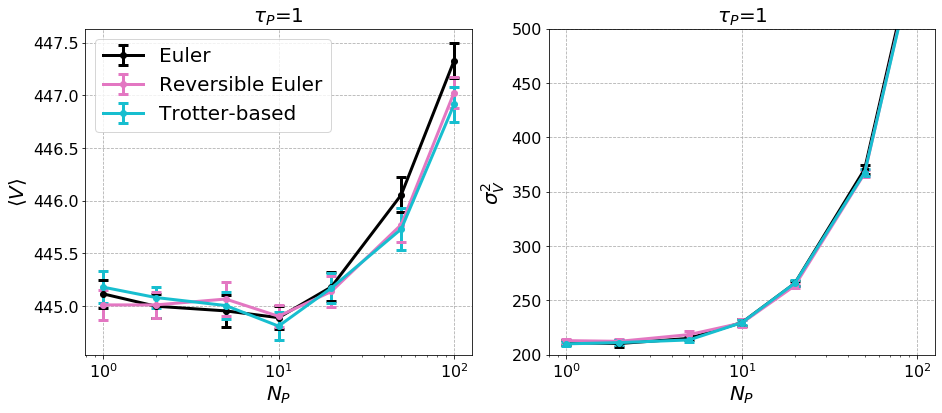

In [25]:
baroscalevs=("F") 
baroscalev=("F")

plt.figure(figsize=(8,6))

plt.subplot(121)

for barotype in barotypes:
    y=[]
    e=[]
    for barostride in barostrides:
        y.append(vol[1.0,barotype,baroscalev,barostride])
        e.append(err_vol[1.0,barotype,baroscalev,barostride])
    label=barotype
    if baroscalev=="T":
        label+="s"
    plt.errorbar(barostrides,y,e,label=barotypes_l[label],
                linewidth=3,capsize=5,capthick=3,fmt='-o',color=colors_l[label])

plt.ylabel(r'$\langle V\rangle$',fontname='Sans',fontsize=20) 
plt.xlabel(r'$N_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')
plt.legend(fontsize=20)
plt.title(r'$\tau_P$=1',fontsize=20)
plt.xscale("log")


plt.subplot(122)
for barotype in barotypes:
    y=[]
    e=[]
    for barostride in barostrides:    
        y.append(sigma2[1.0,barotype,baroscalev,barostride])
        e.append(err_sigma2[1.0,barotype,baroscalev,barostride])
    label=barotype
    if baroscalev=="T":
        label+="s"
    plt.errorbar(barostrides,y[:],e[:],label=label,
                linewidth=3,capsize=5,capthick=3,fmt='-o',color=colors_l[label])
plt.ylim((200,500))
plt.ylabel(r'$\sigma^2_V$',fontname='Sans',fontsize=20) 
plt.xlabel(r'$N_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')
plt.title(r'$\tau_P$=1',fontsize=20)
plt.xscale("log")

plt.subplots_adjust(right=1.6)
plt.show()
#plt.savefig('fig_SI_3b.png',dpi=300,bbox_inches='tight')

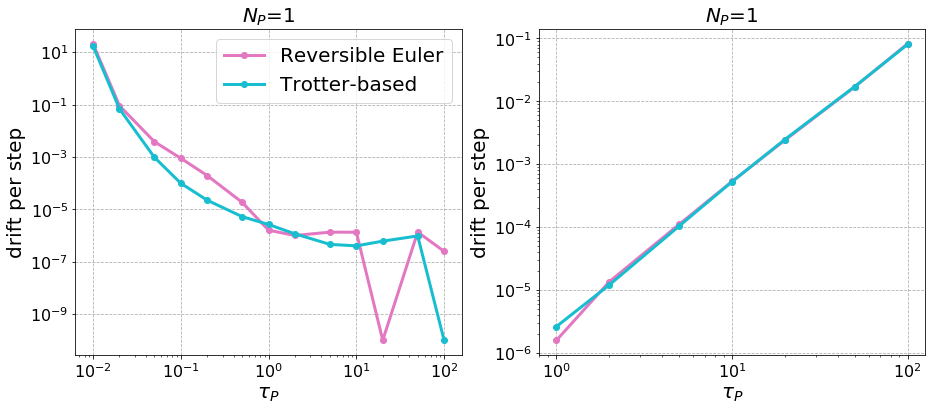

In [27]:
plt.figure(figsize=(8,6))

plt.subplot(121)

for barotype in barotypes:
    for baroscalev in baroscalevs:
    # Notice: for this integrator, effective energy is not well defined
        if barotype!='E':
            y=[]
            e=[]
            for taup in taups:    
                y.append(np.max((drift[taup,barotype,baroscalev,1],1e-10)))
            label=barotype
            if baroscalev=="T":
                label+="s"
            plt.plot(taups,y,'-o',linewidth=3,
                     label=barotypes_l[label],color=colors_l[label])
plt.legend(fontsize=20)
plt.xlabel("taup",fontsize=20)
plt.ylabel('drift per step',fontname='Sans',fontsize=20) 
plt.xlabel(r'$\tau_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')

plt.title(r'$N_P$=1',fontsize=20)
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
for barotype in barotypes:
    # Notice: for these two integrators, effective energy is not well defined
    if barotype!='E' and barotype!='K':
        y=[]
        e=[]
        for barostride in barostrides:
            label=barotype
            if baroscalev=="T":
                label+="s"
            y.append(np.max((drift[1.0,barotype,baroscalev,barostride],1e-10)))
        plt.plot(barostrides,y,'-o',linewidth=3,
                 label=barotypes_l[label],color=colors_l[label])

plt.ylabel('drift per step',fontname='Sans',fontsize=20) 
plt.xlabel(r'$\tau_P$',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')

plt.title(r'$N_P$=1',fontsize=20)
plt.yscale("log")
plt.xscale("log")

plt.subplots_adjust(right=1.6)
plt.show()
#plt.savefig('fig_SI_3c.png',dpi=300,bbox_inches='tight')

## 4. Liquid water: autocorrelation function

In [28]:
tp=np.array([0.1,0.5,1,2]) # explored tau_p values for the liquid water system

In [29]:
# account for different compressibility between GROMACS mdp default settings
# and the actual one for TIP3P waters
tp_fx=tp*(6.9/4.5) 
tp_fx

array([0.15333333, 0.76666667, 1.53333333, 3.06666667])

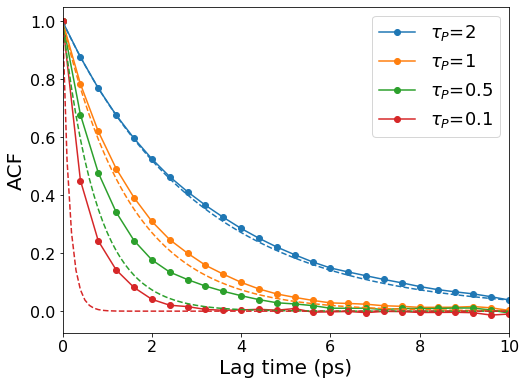

In [30]:
plt.figure(figsize=(8,6))

xmax=100

plt.plot(np.arange(xmax)*0.4,autocorr2(cr_tp2[:,1])[:xmax],label=r'$\tau_P$=2',marker='o') # 0.4 ps stride
plt.plot(np.arange(xmax)*0.4,autocorr2(cr_tp1[:,1])[:xmax],label=r'$\tau_P$=1',marker='o')
plt.plot(np.arange(xmax)*0.4,autocorr2(cr_tp05[:,1])[:xmax],label=r'$\tau_P$=0.5',marker='o')
plt.plot(np.arange(xmax)*0.4,autocorr2(cr_tp01[:,1])[:xmax],label=r'$\tau_P$=0.1',marker='o')

plt.plot(np.arange(0,xmax,0.25)*0.4,np.exp(-np.arange(0,xmax,0.25)*0.4/tp_fx[3]),"--",color='C0')
plt.plot(np.arange(0,xmax,0.25)*0.4,np.exp(-np.arange(0,xmax,0.25)*0.4/tp_fx[2]),"--",color='C1')
plt.plot(np.arange(0,xmax,0.25)*0.4,np.exp(-np.arange(0,xmax,0.25)*0.4/tp_fx[1]),"--",color='C2')
plt.plot(np.arange(0,xmax,0.25)*0.4,np.exp(-np.arange(0,xmax,0.25)*0.4/tp_fx[0]),"--",color='C3')

plt.xlim((0,10))

plt.ylabel('ACF',fontname='Sans',fontsize=20) 
plt.xlabel('Lag time (ps)',fontname='Sans',fontsize=20) 
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.legend(fontsize=18)

plt.show()
#plt.savefig('fig_SI_4.png',dpi=300,bbox_inches='tight')

## 5. Membrane simulation: time series

/u/m/mbernett/my_progs/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


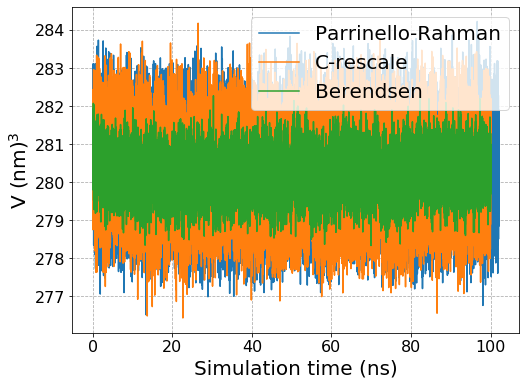

In [36]:
# Volume
plt.figure(figsize=(8,6))
plt.plot(pr_memb[:,0]/1000,pr_memb[:,6],
        label='Parrinello-Rahman')
plt.plot(cr_memb[:,0]/1000,cr_memb[:,6],
        label='C-rescale')
plt.plot(bere_memb[:,0]/1000,bere_memb[:,6],
        label='Berendsen')

plt.legend(fontsize=20)

plt.ylabel('V (nm)$^3$',fontname='Sans',fontsize=20) 
plt.xlabel("Simulation time (ns)",fontsize=20)
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')

plt.show()
#plt.savefig('fig_SI_5a.png',dpi=300,bbox_inches='tight')

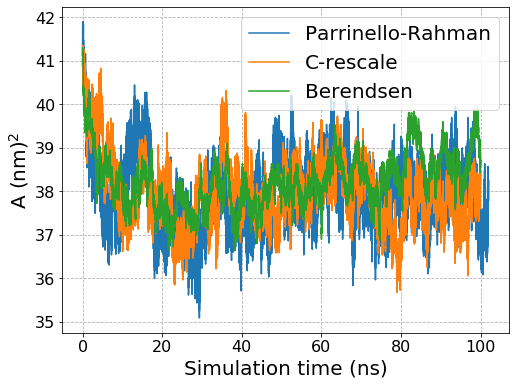

In [39]:
# Area
plt.figure(figsize=(8,6))
plt.plot(pr_memb[:,0]/1000,pr_memb[:,3]*pr_memb[:,4],
        label='Parrinello-Rahman')
plt.plot(cr_memb[:,0]/1000,cr_memb[:,3]*cr_memb[:,4],
        label='C-rescale')
plt.plot(bere_memb[:,0]/1000,bere_memb[:,3]*bere_memb[:,4],
        label='Berendsen')

plt.legend(fontsize=20)

plt.ylabel('A (nm)$^2$',fontname='Sans',fontsize=20) 
plt.xlabel("Simulation time (ns)",fontsize=20)
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')

plt.show()
#plt.savefig('fig_SI_5b.png',dpi=300,bbox_inches='tight')

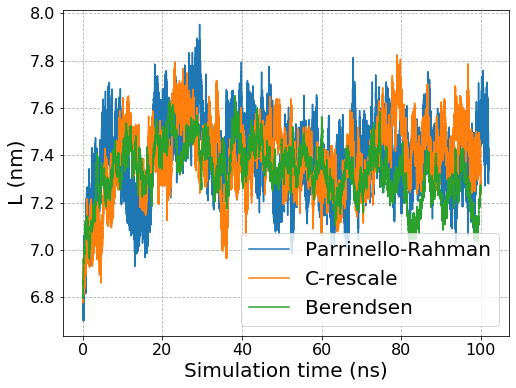

In [40]:
# L
plt.figure(figsize=(8,6))
plt.plot(pr_memb[:,0]/1000,pr_memb[:,5],
        label='Parrinello-Rahman')
plt.plot(cr_memb[:,0]/1000,cr_memb[:,5],
        label='C-rescale')
plt.plot(bere_memb[:,0]/1000,bere_memb[:,5],
        label='Berendsen')

plt.legend(fontsize=20)

plt.ylabel('L (nm)',fontname='Sans',fontsize=20) 
plt.xlabel("Simulation time (ns)",fontsize=20)
plt.yticks(fontname='Sans',fontsize=16)
plt.xticks(fontname='Sans',fontsize=16)
plt.grid(axis="both", linestyle='--')

plt.show()
#plt.savefig('fig_SI_5c.png',dpi=300,bbox_inches='tight')

## Table with performances

In [42]:
nstpc_perfs=[1,5,10,20,40,100]

In [43]:
nvts_err=np.zeros(len(nstpc_perfs))
nvts_err[:]=np.std(nvt_perfs)

nvts=np.zeros(len(pr_perfs))
nvts[:]=np.average(nvt_perfs)

nvts,nvts_err

(array([240.117, 240.117, 240.117, 240.117, 240.117, 240.117]),
 array([2.44272569, 2.44272569, 2.44272569, 2.44272569, 2.44272569,
        2.44272569]))

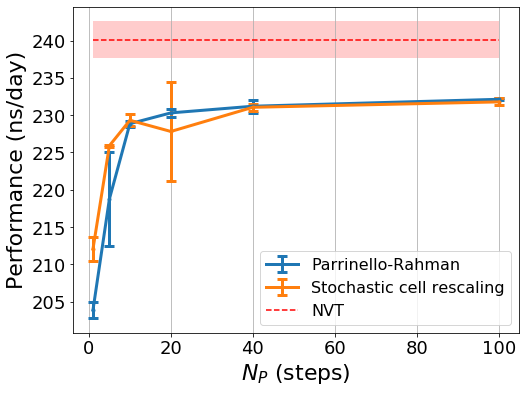

In [45]:
plt.figure(figsize=(8,6))

plt.errorbar(nstpc_perfs,np.average(pr_perfs,axis=1),yerr=np.std(pr_perfs[:,1:],axis=1),
             linewidth=3,capsize=5,capthick=3,marker='.', 
             label='Parrinello-Rahman')
plt.errorbar(nstpc_perfs,np.average(cr_perfs,axis=1),yerr=np.std(cr_perfs[:,1:],axis=1),
             linewidth=3,capsize=5,capthick=3,marker='.', 
             label='Stochastic cell rescaling')
plt.errorbar(nstpc_perfs,nvts,
             color='red',linestyle='--',label='NVT')
plt.fill_between((1,100),nvts[0]+nvts_err[0],nvts[0]-nvts_err[0],facecolor='red',alpha=0.2)

plt.ylabel('Performance (ns/day)',fontname='Sans',fontsize=22)
plt.xlabel(r'$N_P$ (steps)',fontname='Sans',fontsize=22)
plt.yticks(fontname='Sans',fontsize=18)
plt.xticks(fontname='Sans',fontsize=18)

plt.grid(axis='x')
plt.legend(fontsize=16)
plt.show()
#plt.savefig('fig_perform.png',dpi=300,bbox_inches='tight')